In [4]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

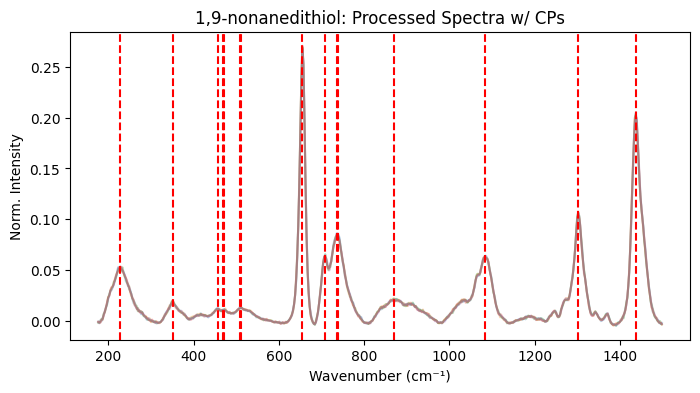

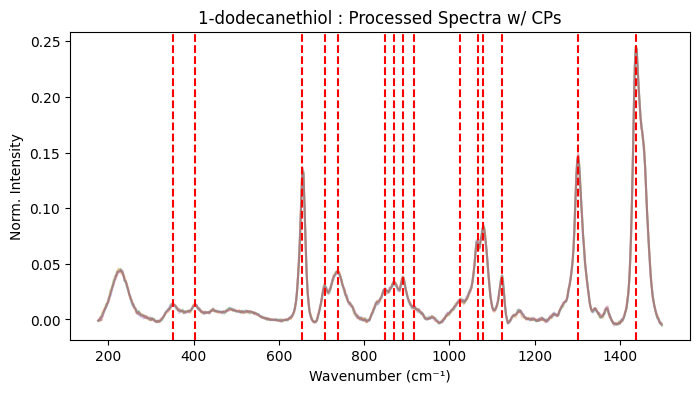

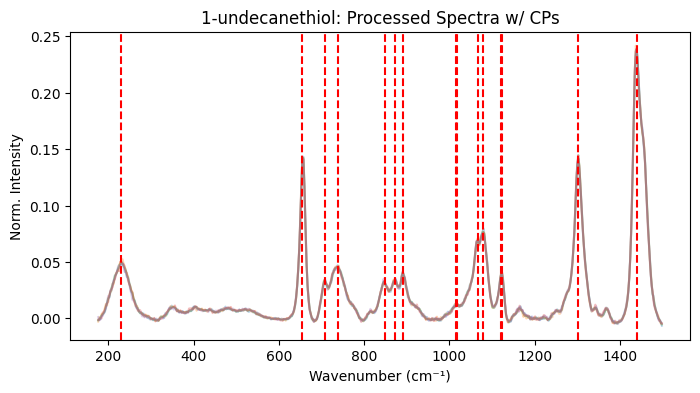

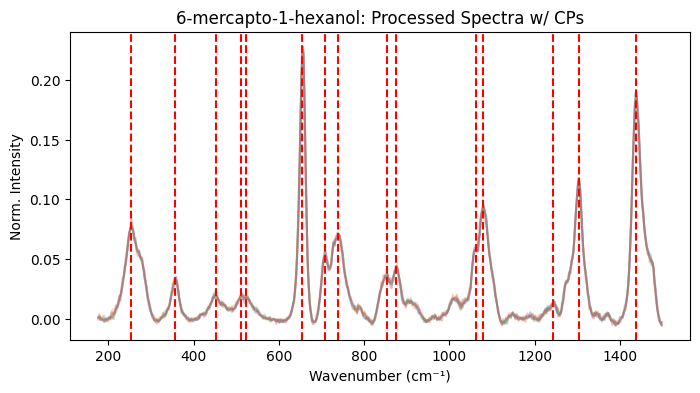

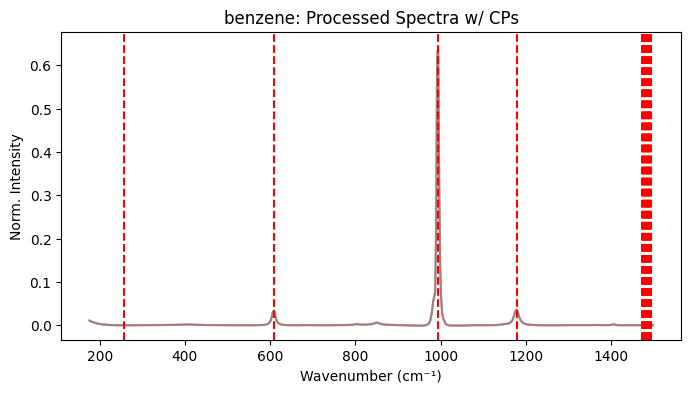

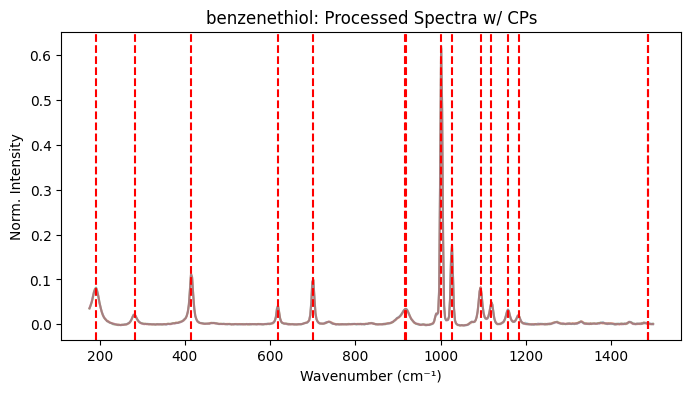

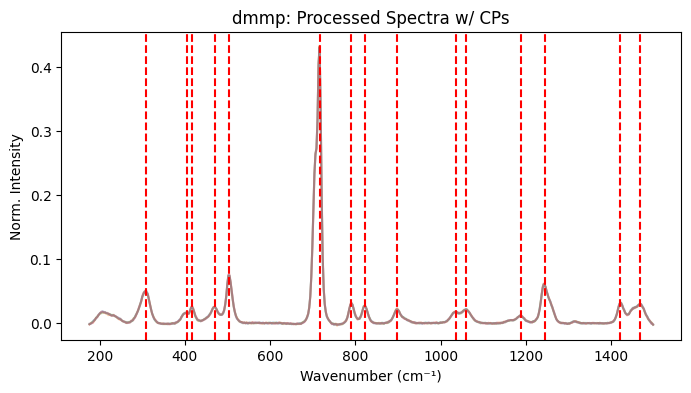

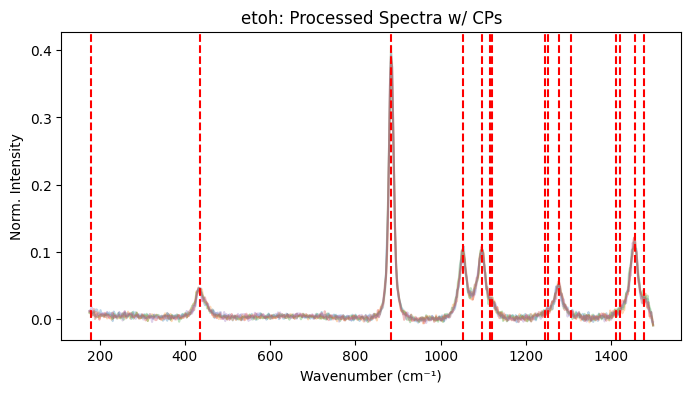

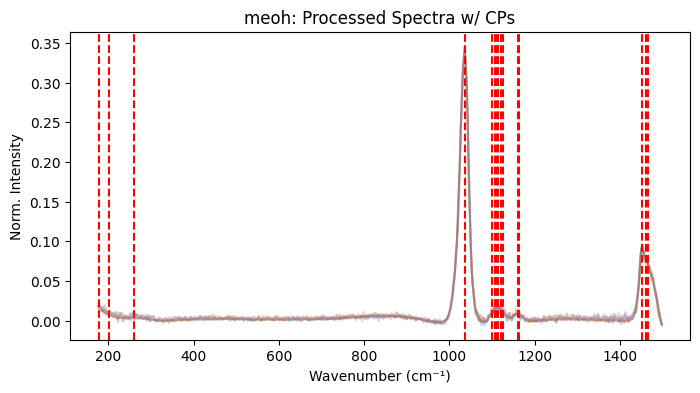

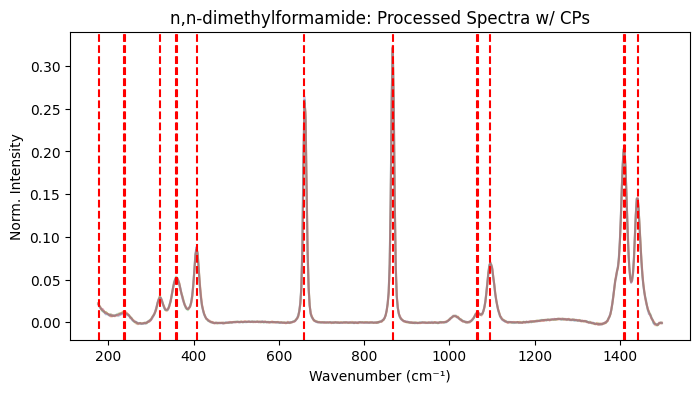

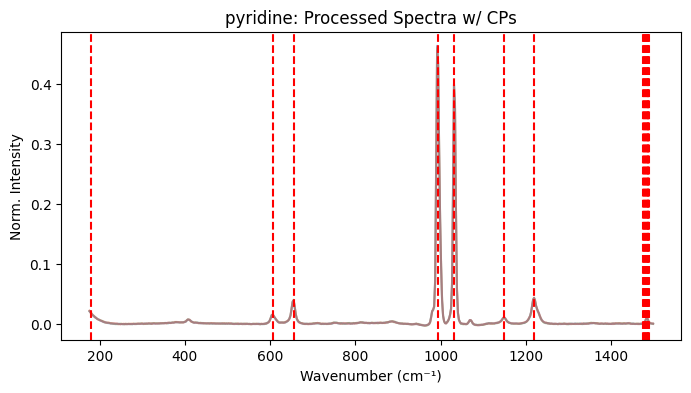

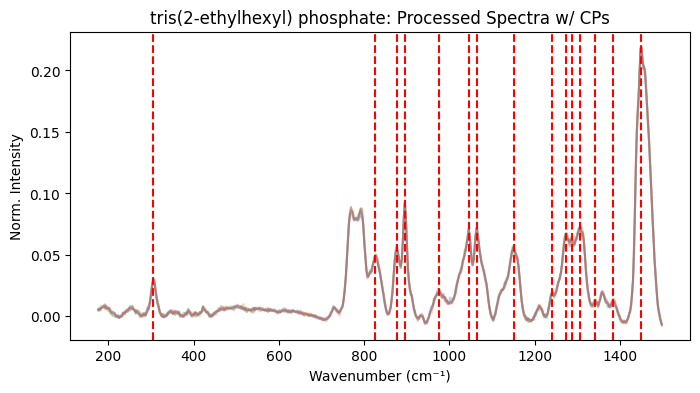

In [9]:
# 1) Load raw data
raw_ref   = pd.read_csv('Jesse_Dataset/reference_subset_1.csv')
wavs_all  = raw_ref.columns[:-1].astype(float)
mask      = (wavs_all <= 1500)  # keep only fingerprint

# 2) Subset your wavenumbers and raw arrays
wavs       = wavs_all[mask]
wavs_str   = raw_ref.columns[:-1][mask]
refs_raw   = raw_ref[wavs_str].values.astype(float)

# 3) Preprocess (baseline + ℓ₂ norm) on cropped data
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1-p) * (y < b)
    return b

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

refs_proc = preprocess(refs_raw)


# 4) Run CaPE and plotting on refs_proc using only wavs and wavs_str
K_smooth, N_peak = 3, 15

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s,height = 0.01)  # Adjust height threshold as needed
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

import matplotlib.pyplot as plt

for chem in sorted(raw_ref['Label'].unique()):
    idxs  = raw_ref.index[raw_ref['Label']==chem]
    refs_p = refs_proc[idxs]
    
    cp_idxs = CaPE(refs_p)
    cp_wavenums = wavs[cp_idxs]

    
    # Overlay spectra
    plt.figure(figsize=(8,4))
    for spec in refs_p:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(w, linestyle='--', color='red')
    plt.title(f"{chem}: Processed Spectra w/ CPs")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Norm. Intensity')
    plt.show()